# Masterthesis Project

In [1]:
# Asking the user for a run name (Unnamed_Run if empty)
run_name = input(
    "EPlease Enter a name for this run (leave blank for 'Unnamed_Run'): "
).strip()
if not run_name:
    run_name = "Unnamed_Run"

## Import of Packages

In [2]:
# Import of Packages
import numpy as np
import time

# Importing the Functions File
import Functions as fn

# Import of Packages for Functions
import random
import matplotlib.pyplot as plt
from deap import base, creator, tools
import itertools

# Import of Packages for Optimization
import scipy.optimize as opt

# Import of Packages for Data Handling
import os
import pickle
from datetime import datetime

# Start of Timer to Measure Runtime
start_time = time.time()

### Log Parameter

In [3]:
# mu = -2.23
# sigma = 0.2  # Adjust this to your actual sigma value

# # Compute the expected mean of lognormal distribution
# lognormal_mean = np.exp(mu + (sigma**2) / 2)
# print(f"Expected mean for mu={mu}, sigma={sigma}: {lognormal_mean}")


# # Function to find mu for a target mean
# def find_mu_for_mean(target_mean, sigma):
#     return np.log(target_mean) - (sigma**2) / 2


# # Compute the correct mu for a desired mean of 0.01
# target_mean = 0.1
# correct_mu = find_mu_for_mean(target_mean, sigma)

# print(f"To get a mean of {target_mean}, set mu={correct_mu:.4f} for sigma={sigma}")

Shock

In [4]:
# # Which One to Use?
# # Shock length
# Exponential if shocks decay quickly over time.
# duration = np.random.exponential(scale=2.5)  # Mean duration ~2.5 years
# # Normal if most drops cluster around an average.
# duration2 = np.random.normal(loc=2.5, scale=1.0)
# duration2 = max(duration2, 0.5)  # Ensure no negative duration
# # Log-Normal if occasional long recoveries exist.
# duration3 = np.random.lognormal(mean=0.8, sigma=0.4)

# # Shock Size
# # Exponential
# delta_demand1 = -np.random.exponential(scale=10)  # Mean drop ~10%
# # Normal
# delta_demand2 = np.random.normal(loc=-20, scale=5)  # Drop in percentage
# # Log-Normal
# delta_demand3 = -np.random.lognormal(mean=2.5, sigma=0.5)  # Always negativ


# # For Random Seed Use
# np.random.seed(np.random.randint(0, 2**16))

# Parameters

ZRH Demand 215'000 ATM per Year ~ 107 DHL
ZRH Loadfcator 80.4% ~ 135 pax Per ATM
Betriebskosten 560 Mio
Aviation Rev 540 Mio
Non Aviatio Rev 626 Mio




In [5]:
Param = {
    "seed": 1,  # Np Random Seed Parameter
    "Dt0": 25000000,  # Demand at t0
    "dt": 1,  # Steptime in Years
    "Fth": 25,  # Time Horizon of Forecasts in Steptime
    "No_Forecasts": 200,  # Number of Forecasts
    "No_Forecasts_plot": 200,  # Number of Forecasts to be plotted
    "mu": 0.042754330256447565,  # Average Demand growth per year
    "sigma": 0.05813761525452841,  # Volatility of Demand development per year
    "lambda": 0.003,  # Average number of shocks per year
    "shock_scale": 1.5,  # Time length of the Shocks
    "shock_drop_scale": 15,  # Scale of the Shock Drop in Percent of Dt0
    "recovery_scale": 1.5,  # Scale of the Recovery
    "recovery_sigma": 0.4,  # Volatility of Recovery
    "recovery_steepness": 0.1,  # Steepness of the Recovery
    "L": 0.9,  # S-Curve Parameter (Saturation now set to 100% as max)
    "k": 0.5,  # S-Curve Parameter (steepness)
    "t0_factor": 0.3,  # S-Curve Parameter t0 (Settle Point)
    "S_curve_offset": 25,  # Offset for S-Curve in Percent
    "p_down": 0.1,  # Probability of a step in the S-Curve being negative
    "scale_up": 1,  # Scale for upward steps on S-Curve
    "scale_down": 1,  # Scale for downward steps on S-Curve
    "LF": 0.8,  # Initial Load Factor
    "smoothing_factor_demand": 0.1,  # Smoothing Factor for the Demand Scenario Trend
    # "smoothing_factor_Load_Factor": 1,  # Smoothing Factor for the Load Factor Trend
    "adjusted_mu": 0.003,  # Adjusted mu for the Load Factor
    "K0": 90,  # Initial Capacity of Jet A1 aircraft stands
    "K0_LH": 0,  # Initial Capacity of LH2 aircraft stands
    "condition": 0,  # Condition for over, under capacity cases
    "p_Dock": 0.55,  # Share of ATMs handled at Dockstands
    "alpha": 0.95,  # Economie of Scale Parameter
    "discount_rate": 0.04,  # Discount rate for NPV calculation
    "Initial_Investment": 1000000,  # Initial investment cost
    "CC_Dock_Jet": 500000,  # Construction cost of Jet A1 aircraft dock stands per unit of K
    "CC_Open_Jet": 300000,  # Construction cost of Jet A1 aircraft open stands per unit of K
    "CC_Dock_LH2": 600000,  # Construction cost of LH2 aircraft dock stands per unit of K
    "CC_Open_LH2": 400000,  # Construction cost of LH2 aircraft dock stands per unit of K
    "CC_Truck_LH2": 70000,  # Acquisition cost of refueling trucks per unit of K (210'000 USD per truck divided by 3 K to be served)
    "CC_Pipeline_LH2": 30000,  # Construction cost of LH2 pipelines per unit of K (5km * 270'000 USD/km divied by 45 K = 30'000 USD/K)
    "TS_D_LH": 100000,  # Threshold for LH2 yearly demand before pipeline installation viable
    "D_LH_Fuel_ATM": 3,  # LH2 Yearly Demand per LH2 Aircraft Movement
    "CE_Dock_Jet": 19,  # Cost of energy and aircon for Jet A1 dockstands per unit of K used ~15.5 für strom und 3.5 für aircon
    "CE_Open_Jet": 15,  # Cost of energy and aircon for Jet A1 openstands per unit of K used
    "CM_Over_Jet": 0,  # Cost of over (unused) Jet A1 stand capacity per unit of K unused
    "CM_Under_Jet": 100,  # Opportunity cost of lacking Jet A1 stand capacity per unit of K missing
    "CE_Dock_LH": 25,  # Cost of energy and aircon for LH2 dockstands per unit of K
    "CE_Open_LH": 19,  # Cost of energy and aircon for LH2 openstands per unit of K
    "CM_Over_LH": 0,  # Cost of over (unused) LH2 stand capacity per unit of K unused
    "CM_Under_LH": 100,  # Opportunity cost of lacking Jet A1 stand capacity per unit of K missing
    "CE_Terminal": 0.5,  # Cost of terminal operations in USD per unit of passenger ~ 0.5 USD
    "re_Dock_Jet": 180,  # Revenue per Jet A1 ATM at dockstands per unit of ATM ~ (80 Standfee, 40 Eneergie, 30 Aircon)*0.75 h ~ 150 USD
    "re_Open_Jet": 120,  # Revenue per Jet A1 ATM at openstands per unit of ATM ~ (60 Standfee, 40 Eneergie, 30 Aircon)*0.75 h ~ 150 USD
    "rf_Jet": 50,  # Revenue from Jet A1 fuel sales per unit of ATM
    "re_Dock_LH": 200,  # Revenue per LH2 ATM at dockstands per unit of ATM
    "re_Open_LH": 150,  # Revenue per LH2 ATM at dockstands per unit of ATM
    "rf_LH": 70,  # Revenue from LH2 fuel sales per unit of ATM
    "re_Pax": 0.5,  # Revenue per passenger within the terminal per unit of passenger ~ 0.5 USD (similar to CE_Terminal)
    "re_Rent": 396,  # Revenue from renting spaces per unit of capacity K ~ (Stand size: 8000 - 12000 m^2 -> 3.3 USD/m^2 * 100 m^2/K -> 330 USD per K for Ground Handling)
    "allowed_values": np.array([0, 1, 2, 3, 4]),  # Capacity Increase Limit
    "population": 1000,  # Number of population mutations in the genetic algorithm
}

# Add time vectors and matrices to Param
Param["time"] = np.arange(1, Param["Fth"] + 2, Param["dt"])

# Number of shocks per Forecast (No_Forecasts)
Param["num_shocks"] = Param["No_Forecasts"] * 0.2

# Mix and Capacity of the Aircraft Types
# Param["Mix"] = np.array([0.8, 0.1, 0.1])  # Short, Medium, Longhaul Mix
Param["Mix"] = np.array([0.57, 0.25, 0.18])  # Short, Medium, Longhaul Mix
Param["Pax_capacity"] = np.array([80, 180, 230])  # Short, Medium, Longhaul Capacity
# Param["deltas"] = np.array([-0.0, +0.000, +0.0])  # Change per time step

# Design Hour Load Limits according to the Infra Slides in Millions of Pax
Param["DHL_Limits"] = np.array([0.0, 1, 10, 20])

# Design Hour Load Factors according to the Infra Slides in Percent
Param["DHL_Factors"] = np.array([0.05, 0.04, 0.035, 0.03])

# Turnaournd Factors for Mix
Param["TTF"] = np.array([1, 1, 1])

# Creating Scenarios

## Passenger Demand

In [6]:
Forecast = fn.Generate_scenarios(Param)
# fn.Scenario_plot(Param, Forecast, True, "Demand Scenarios without Shocks")

Shock_Scenarios = fn.Shock_generation(Param, Forecast, None, False)
# fn.Scenario_plot(Param, Shock_Scenarios, True, "Demand Scenarios with Shocks")

# # To see number of Shocks
# Shock_Scenarios = fn.Shock_generation(Param, Forecast, None, True)
# fn.Scenario_plot(Param, Shock_Scenarios[0], True, "Demand Scenarios with Shocks")
# print("Shocks generated", Shock_Scenarios[1])

## Design Hour Load

In [7]:
PAX_DHL = fn.DHL_Calculation(Param, Shock_Scenarios)
# fn.Scenario_plot(Param, PAX_DHL, True, "Demand Hour Load", "Passenger Demand per Hour")

## Load Factor

In [8]:
Load_Factor_matrix = fn.Load_Factor_matrix(Param, PAX_DHL)
# fn.Scenario_plot(Param, Load_Factor_matrix, True, "Load Factor")

## Air Traffic Movements

In [9]:
d_ATM, d_ATM_mix = fn.ATM(Param, PAX_DHL, Load_Factor_matrix)

### Plotting the ATM

In [10]:
# fn.Scenario_plot(
#     Param,
#     d_ATM,
#     True,
#     "Total Air Traffic Movements",
#     "Number of Aircraft Movements in the Design Hour",
# )


# fn.ATM_plot(d_ATM_mix, Param)

## S-Curve

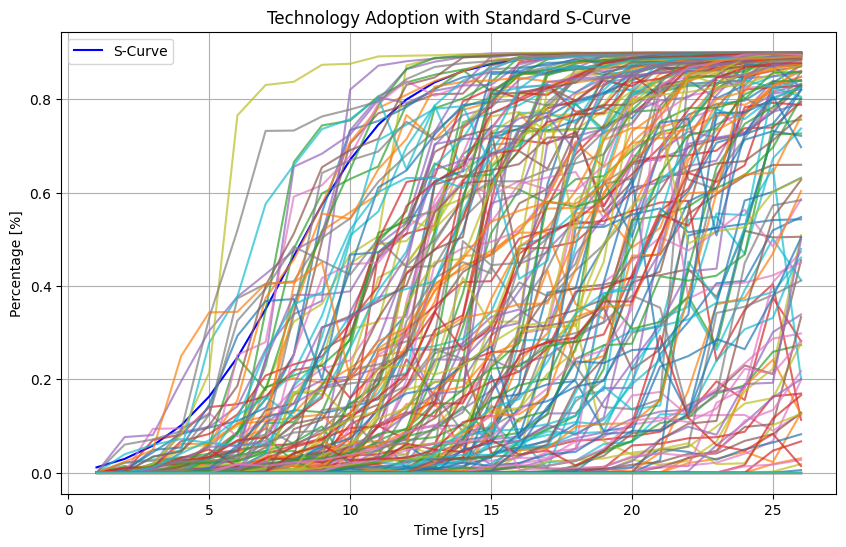

In [11]:
S_value_matrix = fn.S_curve(Param)
fn.S_curve_plot(
    Param,
    S_value_matrix,
)

# fn.Scenario_plot(
#     Param,
#     S_value_matrix,
#     NoStep=True,
#     Title="Technology Adoption without Standard S-Curve",
#     label="Percentage [%]",
# )

## Hydrogen Adoption

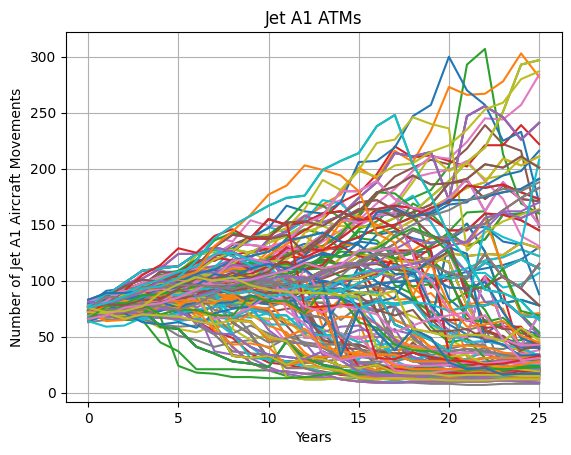

In [12]:
d_ATM_LH, d_ATM_LH_mix = fn.LH2_technology_adoption(Param, S_value_matrix, d_ATM_mix)

# fn.Scenario_plot(Param, d_ATM_LH, True, "LH2 ATMs", "Number of LH2 Aircraft Movements")
# fn.ATM_plot(d_ATM_LH_mix, Param)

d_ATM_Jet = d_ATM - d_ATM_LH
fn.Scenario_plot(
    Param, d_ATM_Jet, True, "Jet A1 ATMs", "Number of Jet A1 Aircraft Movements"
)

d_ATM_Jet_mix = np.round(d_ATM_mix - d_ATM_LH_mix, 0)
# fn.ATM_plot(d_ATM_Jet_mix, Param)

# Completed Scenarios

In [13]:
# # Passenger Demand Scenario
# print("Pax: \t\t", Shock_Scenarios.shape)

# # Air Traffic Mix Scenario
# print("ATM Demand: \t", d_ATM.shape)
# print("ATM Mix Demand: ", d_ATM_mix.shape)

# # Technology Adoption Scenario
# print("S-Curve Values: ", S_value_matrix.shape)

## Yearly Stand Demand

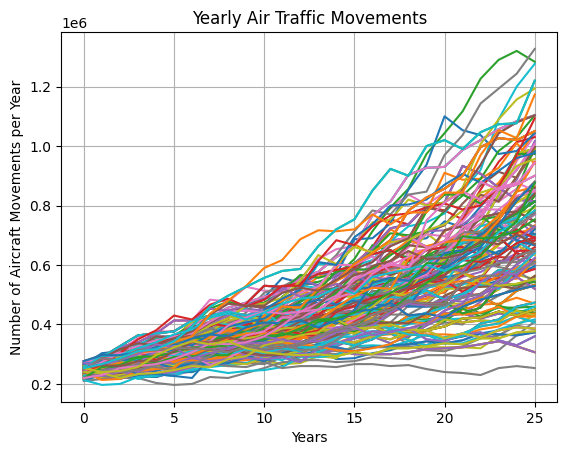

In [14]:
D_ATM, D_ATM_mix = fn.ATM_yearly(Param, d_ATM)

fn.Scenario_plot(
    Param,
    D_ATM,
    True,
    "Yearly Air Traffic Movements",
    "Number of Aircraft Movements per Year",
)

# fn.ATM_plot(D_ATM_mix, Param)

# Optimization Alorithm

In [15]:
GA_dual = fn.GA_dual(Param, d_ATM_mix, S_value_matrix, Shock_Scenarios)
delta_K_GA = GA_dual[0] + GA_dual[1]

print(delta_K_GA.shape)
# print(delta_K_GA)

(200, 26, 3)


In [16]:
NPV_GA = fn.NPV_calculation(
    Param,
    GA_dual[0],
    GA_dual[1],
    d_ATM_mix,
    S_value_matrix,
    Shock_Scenarios,
)

# print(NPV_GA)

## Visulization of Jet A1 Aircraft Stand Capacity

In [17]:
# K_GA_Jet = fn.Capacity_2D(Param, GA_dual[0])
# fn.Scenario_plot(Param, K_GA_Jet, True, "GA Output Jet", "Capacity K Jet")
# fn.Scenario_plot(
#     Param,
#     np.vstack((K_GA_Jet, d_ATM_Jet)),
#     True,
#     "GA Output Jet",
#     "Capacity K Jet",
# )

## Visulization of LH2 Aircraft Stand Capacity

In [18]:
# K_GA_LH = fn.Capacity_2D(Param, GA_dual[1], True)
# fn.Scenario_plot(Param, K_GA_LH, True, "GA Output LH", "Capacity K LH")
# fn.Scenario_plot(
#     Param,
#     np.vstack((K_GA_LH, d_ATM_LH)),
#     True,
#     "GA Output LH",
#     "Capacity K LH",
# )

## Visulization of Total Aircraft Stand Capacity

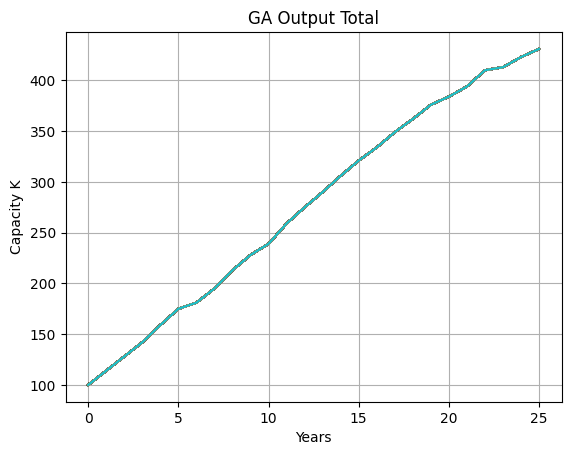

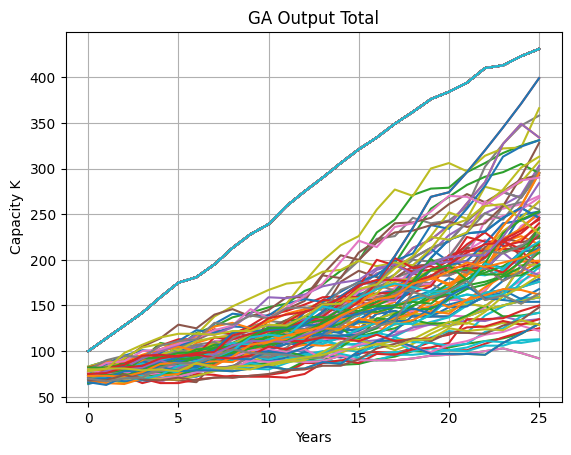

In [19]:
K_GA_total = fn.Capacity_2D(Param, delta_K_GA)

fn.Scenario_plot(Param, K_GA_total, True, "GA Output Total", "Capacity K")
fn.Scenario_plot(
    Param, np.vstack((K_GA_total, d_ATM)), True, "GA Output Total", "Capacity K"
)

In [20]:
k_GA, k_GA_mix = fn.K_yearly(Param, K_GA_total)

# Decision Rule

## Parameters for Decision Rule Optimization

In [21]:
Param["lower_theta"] = 0
Param["upper_theta"] = 12
Param["stepsize_theta"] = 1
Param["lower_condition"] = 2
Param["upper_condition"] = 6
Param["stepsize_condition"] = 1

## Parameter Evaluation

In [22]:
# Parameter_Evaluation
ENPV_Decision, Parameter_Decision = fn.Parameter_Evaluation(
    Param,
    d_ATM_Jet_mix,
    d_ATM_LH_mix,
    d_ATM_mix,
    S_value_matrix,
    Shock_Scenarios,
    10000,
    True,
)
print("Maximum ENPV:", ENPV_Decision)
print("Best Parameters:", Parameter_Decision)

Maximum ENPV: 502760990.2730846
Best Parameters: (10, 4, 2, 2, 11, 11, 9, 3)


## Visualization of the Decision Rule

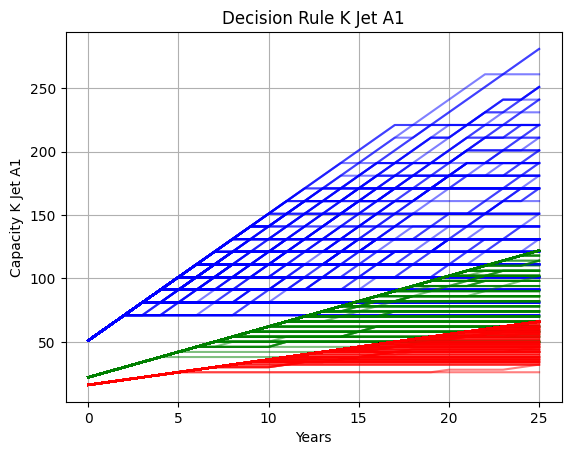

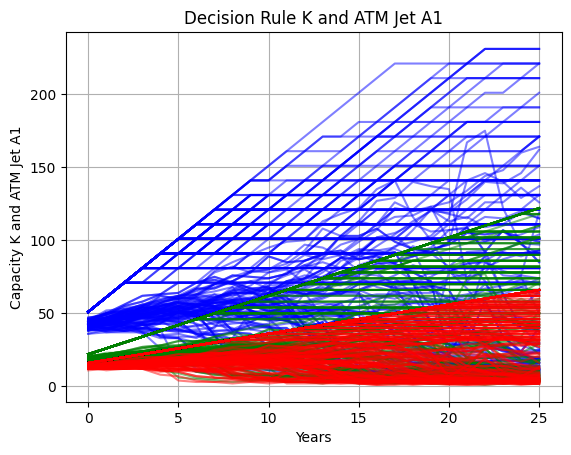

In [23]:
delta_K_Jet_Decision_short = fn.Decision_Rule(
    Param,
    Param["K0"] * Param["Mix"][0],
    d_ATM_Jet,
    Parameter_Decision[0],
    Parameter_Decision[3],
)
delta_K_Jet_Decision_medium = fn.Decision_Rule(
    Param,
    Param["K0"] * Param["Mix"][1],
    d_ATM_Jet,
    Parameter_Decision[1],
    Parameter_Decision[3],
)
delta_K_Jet_Decision_long = fn.Decision_Rule(
    Param,
    Param["K0"] * Param["Mix"][2],
    d_ATM_Jet,
    Parameter_Decision[2],
    Parameter_Decision[3],
)
delta_K_Jet_Decision_mix = np.stack(
    [
        delta_K_Jet_Decision_short,
        delta_K_Jet_Decision_medium,
        delta_K_Jet_Decision_long,
    ],
    axis=2,
)


K_Jet_Decision = fn.Capacity_3D(Param, delta_K_Jet_Decision_mix, False)

fn.Scenario_plot(
    Param,
    K_Jet_Decision,
    True,
    "Decision Rule K Jet A1",
    "Capacity K Jet A1",
)

fn.Scenario_plot(
    Param,
    np.vstack((d_ATM_Jet_mix, K_Jet_Decision)),
    True,
    "Decision Rule K and ATM Jet A1",
    "Capacity K and ATM Jet A1",
)

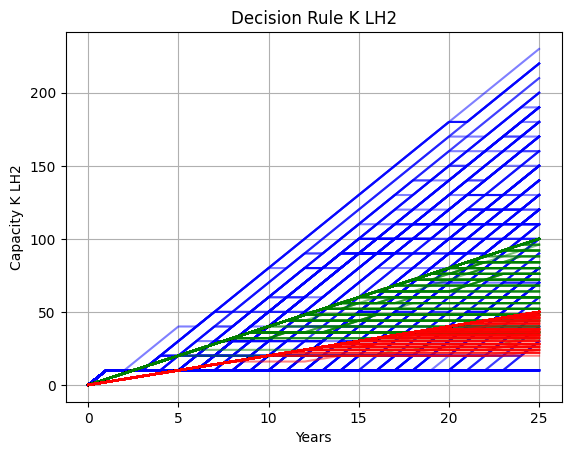

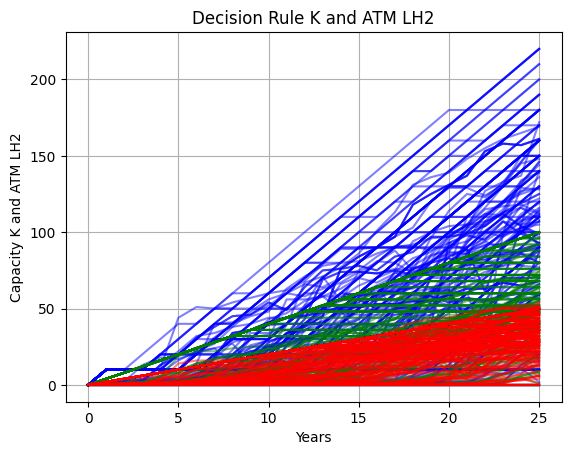

In [24]:
delta_K_LH_Decision_short = fn.Decision_Rule(
    Param,
    Param["K0_LH"] * Param["Mix"][0],
    d_ATM_LH,
    Parameter_Decision[0],
    Parameter_Decision[3],
)
delta_K_LH_Decision_medium = fn.Decision_Rule(
    Param,
    Param["K0_LH"] * Param["Mix"][1],
    d_ATM_Jet,
    Parameter_Decision[1],
    Parameter_Decision[3],
)
delta_K_LH_Decision_long = fn.Decision_Rule(
    Param,
    Param["K0_LH"] * Param["Mix"][2],
    d_ATM_Jet,
    Parameter_Decision[2],
    Parameter_Decision[3],
)
delta_K_LH_Decision_mix = np.stack(
    [
        delta_K_LH_Decision_short,
        delta_K_LH_Decision_medium,
        delta_K_LH_Decision_long,
    ],
    axis=2,
)


K_LH_Decision = fn.Capacity_3D(Param, delta_K_LH_Decision_mix, True)
fn.Scenario_plot(
    Param,
    K_LH_Decision,
    True,
    "Decision Rule K LH2",
    "Capacity K LH2",
)
fn.Scenario_plot(
    Param,
    np.vstack((d_ATM_LH_mix, K_LH_Decision)),
    True,
    "Decision Rule K and ATM LH2",
    "Capacity K and ATM LH2",
)

### Decision 3 -> Optimize delta K for Mix (Short, Medium, Longhaul) and combine again for general Result

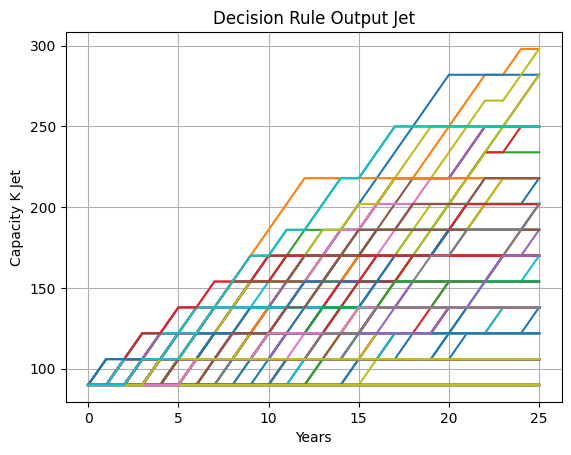

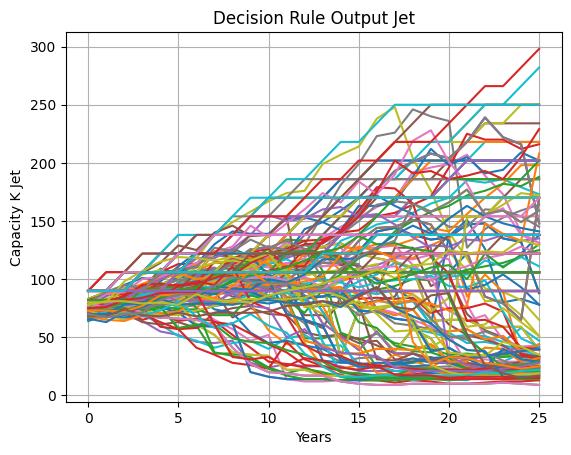

In [25]:
cond_Jet_Decision = Parameter_Decision[3]
theta_Jet_Decision = (
    Parameter_Decision[0] + Parameter_Decision[1] + Parameter_Decision[2]
)


delta_K_Jet_Decision_3 = fn.Decision_Rule(
    Param, Param["K0"], d_ATM_Jet, theta_Jet_Decision, cond_Jet_Decision
)
K_Jet_Decision_3 = fn.Capacity_2D(Param, delta_K_Jet_Decision_3)
fn.Scenario_plot(
    Param, K_Jet_Decision_3, True, "Decision Rule Output Jet", "Capacity K Jet"
)
fn.Scenario_plot(
    Param,
    np.vstack((K_Jet_Decision_3, d_ATM_Jet)),
    True,
    "Decision Rule Output Jet",
    "Capacity K Jet",
)

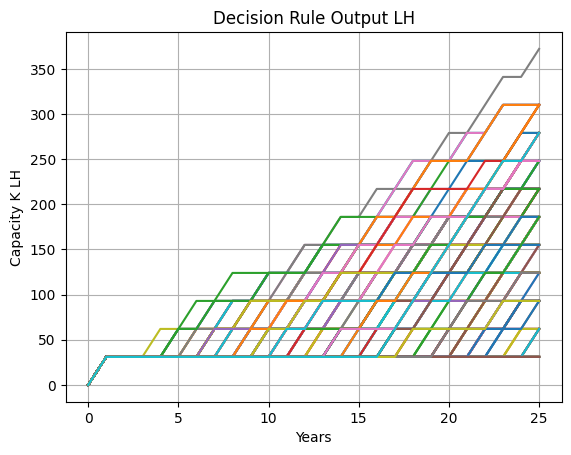

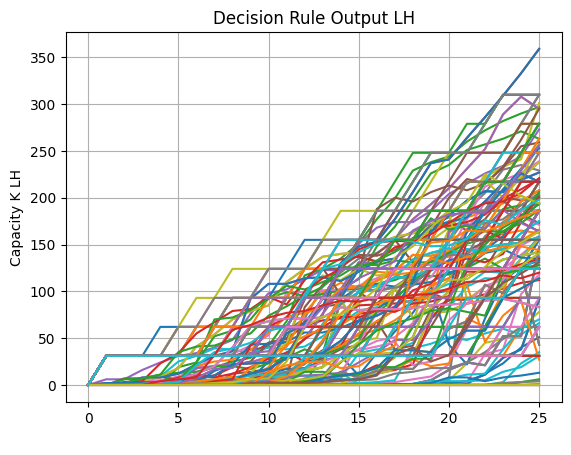

In [26]:
cond_LH_Decision = Parameter_Decision[7]
theta_LH_Decision = (
    Parameter_Decision[4] + Parameter_Decision[5] + Parameter_Decision[6]
)

delta_K_LH_Decision_3 = fn.Decision_Rule(
    Param, Param["K0_LH"], d_ATM_LH, theta_LH_Decision, cond_LH_Decision
)
K_LH_Decision_3 = fn.Capacity_2D(Param, delta_K_LH_Decision_3, True)
fn.Scenario_plot(
    Param, K_LH_Decision_3, True, "Decision Rule Output LH", "Capacity K LH"
)
fn.Scenario_plot(
    Param,
    np.vstack((K_LH_Decision_3, d_ATM_LH)),
    True,
    "Decision Rule Output LH",
    "Capacity K LH",
)

# NPV Calculation

In [27]:
# NPV_Decision = fn.NPV_calculation(
#     Param,
#     delta_K_Jet_Decision_0,
#     delta_K_LH_Decision_0,
#     d_ATM_mix,
#     S_value_matrix,
#     Shock_Scenarios,
# )

# print(np.mean(NPV_Decision))
# print(ENPV_Decision)

In [28]:
# NPV_Decision_2 = fn.NPV_calculation(
#     Param,
#     delta_K_Jet_Decision_2,
#     delta_K_LH_Decision_2,
#     d_ATM_mix,
#     S_value_matrix,
#     Shock_Scenarios,
# )

# print(np.mean(NPV_Decision_2))
# print(ENPV_Decision_2)

In [29]:
NPV_Decision_3 = fn.NPV_calculation(
    Param,
    delta_K_Jet_Decision_3,
    delta_K_LH_Decision_3,
    d_ATM_mix,
    S_value_matrix,
    Shock_Scenarios,
)

print(np.mean(NPV_Decision_3))
# print(ENPV_Decision_3)

509849881.8329342


In [30]:
p_ENPV = np.mean(NPV_Decision_3) / np.mean(NPV_GA)
print(p_ENPV - 1)

0.13475548446771057


# CDF Plot

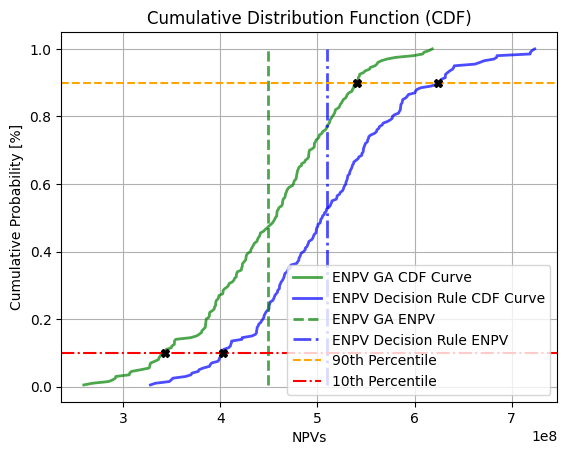

10th Percentile ENPV GA: 342955586.5309482, 90th Percentile ENPV GA: 540862587.4932691
10th Percentile ENPV Decision Rule: 402874162.56564814, 90th Percentile ENPV Decision Rule: 623611748.3132492
 ENPV GA: 449303738.8332993, ENPV Decision Rule: 509849881.8329342
ENPV_GA: 		 449303738.8332993
ENPV_Decision Rule: 	 509849881.8329342


In [31]:
fn.CDF_Plot(
    NPV_GA,
    NPV_Decision_3,
    "ENPV GA",
    "ENPV Decision Rule",
)
print("ENPV_GA: \t\t", np.mean(NPV_GA))
print("ENPV_Decision Rule: \t", np.mean(NPV_Decision_3))

# Stopping the Runtime

In [32]:
end_time = time.time()

# Calculate the Total Runtime
total_run_time = end_time - start_time

# Display the Total Runtime
print("Total Runtime \t=", round(total_run_time, 2), "s")
print("Total Runtime \t=", round(total_run_time / 60, 2), "min")
print("Total Runs \t=", Param["No_Forecasts"])

Total Runtime 	= 81.38 s
Total Runtime 	= 1.36 min
Total Runs 	= 200


I adjusted the second smoothing (smoothing of Load Factor). Currently it is out commented in the Function as it safes 1/3 of the time. For "No_Forecasts": 30000 the Code takes 20 instead of 30 seconds.

# Multiprocessing

In [33]:
# import multiprocessing


# input_list = [Param.copy() for _ in range(Param["No_Forecasts"])]

# # Create a pool of worker processes
# with multiprocessing.Pool(processes=8) as pool:
#     results = pool.map(fn.ATM, input_list)  # Map function to pool

In [34]:
# from multiprocessing import Pool

# # input_list = list of each scenario (rows of Shock_forecast)
# input_list = [row for row in Shock_Scenarios]  # shape: [No_Forecasts, Fth]
# args_list = [(Param, scenario) for scenario in input_list]

# with Pool(processes=8) as pool:
#     results = pool.starmap(fn.Load_Factor_matrix, args_list)

In [35]:
# import multiprocessing as mp


# # Helper function for multiprocessing
# def compute_load_factor(scenario):
#     return fn.Load_Factor_matrix(Param, scenario)


# if __name__ == "__main__":
#     # Number of processes (or use mp.cpu_count())
#     pool = mp.Pool(processes=4)

#     # Map each scenario to the worker pool
#     results = pool.map(compute_load_factor, Shock_Scenarios)

#     pool.close()
#     pool.join()

#     # Combine results if needed (e.g., into a matrix)
#     LF_test_matrix = np.array(results)  # Or pd.DataFrame(results), etc.

## Loading Bar

In [36]:
# from tqdm.auto import tqdm

### Example Usage

In [37]:
# # Generate input list with separate dictionary copies
# input_list = [Param.copy() for _ in range(Param["No_Forecasts"])]

# # Create a pool of worker processes
# with multiprocessing.Pool(processes=8) as pool:
#     # Use imap_unordered for better progress tracking with tqdm
#     results = list(
#         tqdm(
#             pool.imap_unordered(fn.ATM, input_list),
#             total=len(input_list),
#             desc="Processing Forecasts",
#         )
#     )

# Saving the Data in a Pickle File

In [38]:
No_Forecasts = Param["No_Forecasts"]

# Timestamp
timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# File name
filename = "MT_Data.pkl"

# Load existing data if file exists, else start a new list
if os.path.exists(filename):
    with open(filename, "rb") as f:
        data = pickle.load(f)
else:
    data = []

# Construct new record
record = {
    "Run_Name": run_name,
    "Timestamp": timestamp,
    "Total_Runtime": total_run_time,
    "Param": Param,
    "No_Forecasts": No_Forecasts,
    "d_ATM": d_ATM,
    "S_Values": S_value_matrix,
    "Shock_Scenarios": Shock_Scenarios,
    "delta_K_GA": delta_K_GA,
    "NPV_GA": NPV_GA,
    "ENPV_GA": np.mean(NPV_GA),
    "delta_K_Jet_Decision": delta_K_Jet_Decision_3,
    "Parameter_Decision": Parameter_Decision,
    "NPV_Decision": NPV_Decision_3,
    "ENPV_Decision": ENPV_Decision,
}

# Append current run
data.append(record)

# Save back to pickle file
with open(filename, "wb") as f:
    pickle.dump(data, f)

print(f"Run '{run_name}' saved to MT_Data.pkl at {timestamp}")

Run 'x' saved to MT_Data.pkl at 2025-08-01 14:10:50


To delete a Test Run, uncomment this code and enter the name of the Run in the Box

In [39]:
# run_name_to_delete = input("Enter the name of the run to delete: ").strip()

# new_runs = [run for run in all_runs if run["Run_Name"] != run_name_to_delete]

# if len(new_runs) < len(all_runs):
#     with open(filename, "wb") as f:
#         pickle.dump(new_runs, f)
#     print(f"Deleted all runs named '{run_name_to_delete}'")
# else:
#     print("No runs found with that name.")

## Visualizing the Data

In [40]:
# Load the pickle file
with open("MT_Data.pkl", "rb") as f:
    all_runs = pickle.load(f)

# Print summary of all runs
print(f"\nTotal runs stored: {len(all_runs)}\n")

for i, run in enumerate(all_runs):
    print(f"=== Run {i + 1} ===")
    print("Run Name:    ", run["Run_Name"])
    print("No_Forecasts:", run["No_Forecasts"])
    print("Total Runtime:", round(run["Total_Runtime"], 2), "s")
    print("Timestamp:   ", run["Timestamp"])
    print("Keys:", list(run.keys()))
    print("ENPV_GA:     ", run["ENPV_GA"])
    print("ENPV_Decision:", run["ENPV_Decision"])
    print("Parameters:  ", run["Parameter_Decision"])
    print("Param", run["Param"])


Total runs stored: 5

=== Run 1 ===
Run Name:     x
No_Forecasts: 200
Total Runtime: 80.88 s
Timestamp:    2025-08-01 13:48:07
Keys: ['Run_Name', 'Timestamp', 'No_Forecasts', 'Total_Runtime', 'd_ATM', 'S_Values', 'Shock_Scenarios', 'delta_K_GA', 'NPV_GA', 'ENPV_GA', 'delta_K_Jet_Decision', 'Parameter_Decision', 'NPV_Decision', 'ENPV_Decision', 'Param']
ENPV_GA:      469898895.72956824
ENPV_Decision: 512689469.59484106
Parameters:   (11, 7, 3, 2, 6, 3, 3, 2)
Param {'seed': 1, 'Dt0': 25000000, 'dt': 1, 'Fth': 25, 'No_Forecasts': 200, 'No_Forecasts_plot': 200, 'mu': 0.042754330256447565, 'sigma': 0.05813761525452841, 'lambda': 0.003, 'shock_scale': 1.5, 'shock_drop_scale': 15, 'recovery_scale': 1.5, 'recovery_sigma': 0.4, 'recovery_steepness': 0.1, 'L': 0.4, 'k': 0.5, 't0_factor': 0.7, 'S_curve_offset': 25, 'p_down': 0.1, 'scale_up': 1, 'scale_down': 1, 'LF': 0.8, 'smoothing_factor_demand': 0.1, 'adjusted_mu': 0.003, 'K0': 90, 'K0_LH': 0, 'condition': 0, 'p_Dock': 0.55, 'alpha': 0.95, 'd

## Plotting the saved data

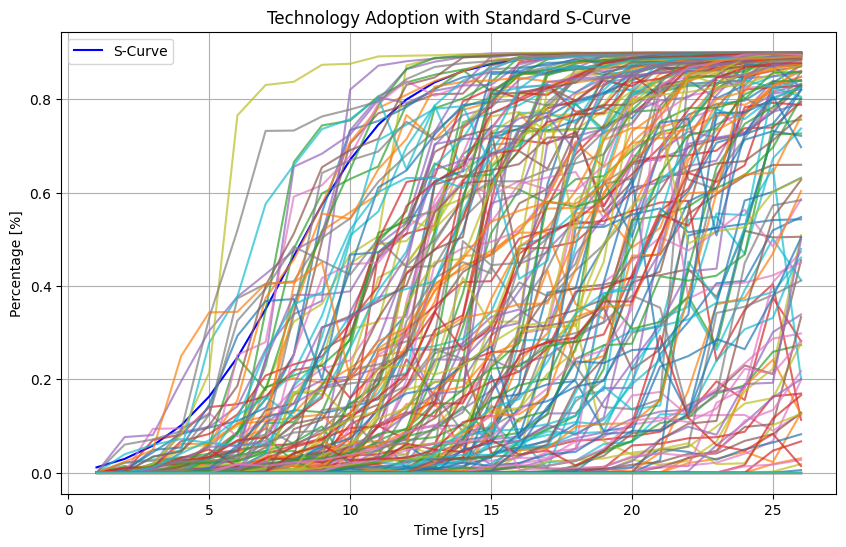

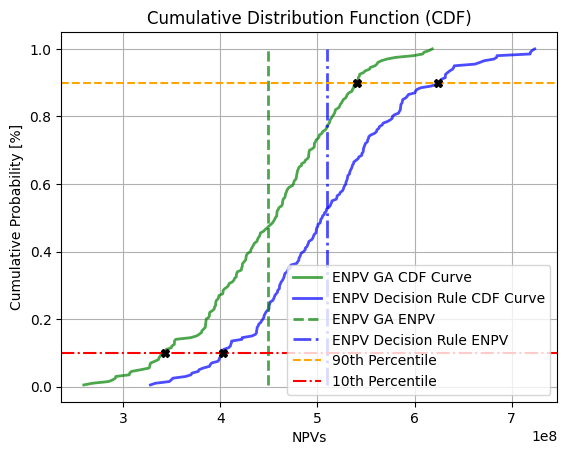

10th Percentile ENPV GA: 342955586.5309482, 90th Percentile ENPV GA: 540862587.4932691
10th Percentile ENPV Decision Rule: 402874162.56564814, 90th Percentile ENPV Decision Rule: 623611748.3132492
 ENPV GA: 449303738.8332993, ENPV Decision Rule: 509849881.8329342


[342955586.5309482, 540862587.4932691, 402874162.56564814, 623611748.3132492]

In [41]:
Run = -1

fn.S_curve_plot(
    all_runs[Run]["Param"],
    all_runs[Run]["S_Values"],
)


fn.CDF_Plot(
    all_runs[Run]["NPV_GA"],
    all_runs[Run]["NPV_Decision"],
    "ENPV GA",
    "ENPV Decision Rule",
)